<a href="https://colab.research.google.com/github/seoyujiin/esaa_ob/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_3%EC%9E%A5_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**CHAPTER 3 분류**

###**3.1 MNIST**

MNIST 데이터셋: 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지를 모은 것

In [ ]:
# MNIST 데이터셋 내려받는 코드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)  # as_frame=False 지정해야 X[0] 돌아감
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있음

* 데이터셋 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [ ]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

→ 이미지가 70,000개 있고 각 이미지에는 784개의 특성이 있음(이미지가 28x28 픽셀이기 때문)

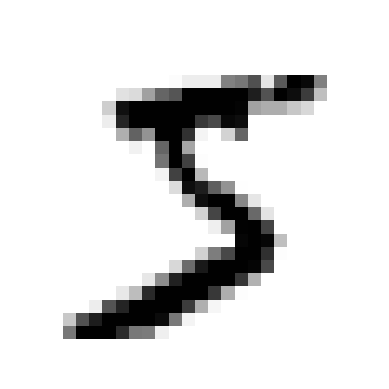

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

→ 그림은 숫자 5로 보이는데 실제 레이블 확인 결과 문자열

→ 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

In [ ]:
import numpy as np
y = y.astype(np.uint8)

In [ ]:
# 테스트 세트와 훈련 세트 나누기
# 앞쪽 60,000개 이미지는 훈련세트, 뒤쪽 10,000개 이미지는 테스트세트
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

* 훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만듦(하나의 폴드라도 특정 숫자가 누락되면 안 됨)
* 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 많은 비슷한 샘플이 연이어 나타나면 성능 나빠짐
* 데이터셋을 섞으면 이런 문제를 방지할 수 있음

###**3.2 이진 분류기 훈련**

이진 분류기: 두 개의 클래스 구분

In [ ]:
y_train_5 = (y_train == 5)  # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == 5)

* 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(Stochastic Gradient Descent, SGD) 분류기로 훈련(매우 큰 데이터셋을 효율적으로 처리하는 장점)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
# 위 모델을 사용해 숫자 5의 이미지 감지
sgd_clf.predict([some_digit])

array([ True])

→ 분류기는 이 이미지가 5를 나타낸다고 추측(True)

###**3.3 성능 측정**

**3.3.1 교차 검증을 사용한 정확도 측정**


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


→ 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과를 출력

→ StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행함, 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측을 만듦, 그런 다음 올바른 예측의 수를 세어 정확한 예측의 비율을 출력함

In [ ]:
# cross_val_score() 함수로 폴드가 3개인 K-겹 교차 검증을 사용해 SGDClassifier 모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

→ 모든 교차 검증 폴드에 대해 정확도가 95% 이상

In [ ]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [ ]:
# 모델의 정확도 추측
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

→ 정확도가 90% 이상

→ 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%임

→ 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌, 특히 불균형한 데이터셋을 다룰 때, 즉 어떤 클래스가 다른 것보다 월등히 많은 경우 더욱 그러함

**3.3.2 오차 행렬**

* 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것
* 기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것
  * ex) 분류기가 숫자 5의 이미지를 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 됨
* 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 먼들어야 함
* 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안 됨(테스트 세트는 분류기가 출시 준비를 마치고 나서 프로젝트의 맨 마지막에 사용됨) → 대신 cross_val_predict() 함수 사용

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

→ cross_val_score() 함수처럼 cross_val_predict() 함수는 k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환함

→ 즉 훈련 세트의 모든 샘플에 대해 깨끗한 예측을 얻게 됨(모델이 훈련하는 동안 보지 못했던 데이터에 대해 예측했다는 의미)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

→ 오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄

→ 이 행렬의 첫 번째 행은 '5 아님' 이미지(negative class)에 대한 것으로, 53892개를 '5 아님'으로 정확하게 분류했고(true negative) 나머지 687개는 '5'라고 잘못 분류함(false positive)

→ 두 번째 행은 '5' 이미지(positive class)에 대한 것으로 1891개를 '5 아님'으로 잘못 분류했고(false negative) 나머지 3530개를 정확히 '5'라고 분류함(true positive)

→ 완벽한 분류기라면 true positive와  true negative만 가지고 있을 것이므로 오차 행렬의 주대각선만 0이 아닌 값이 됨

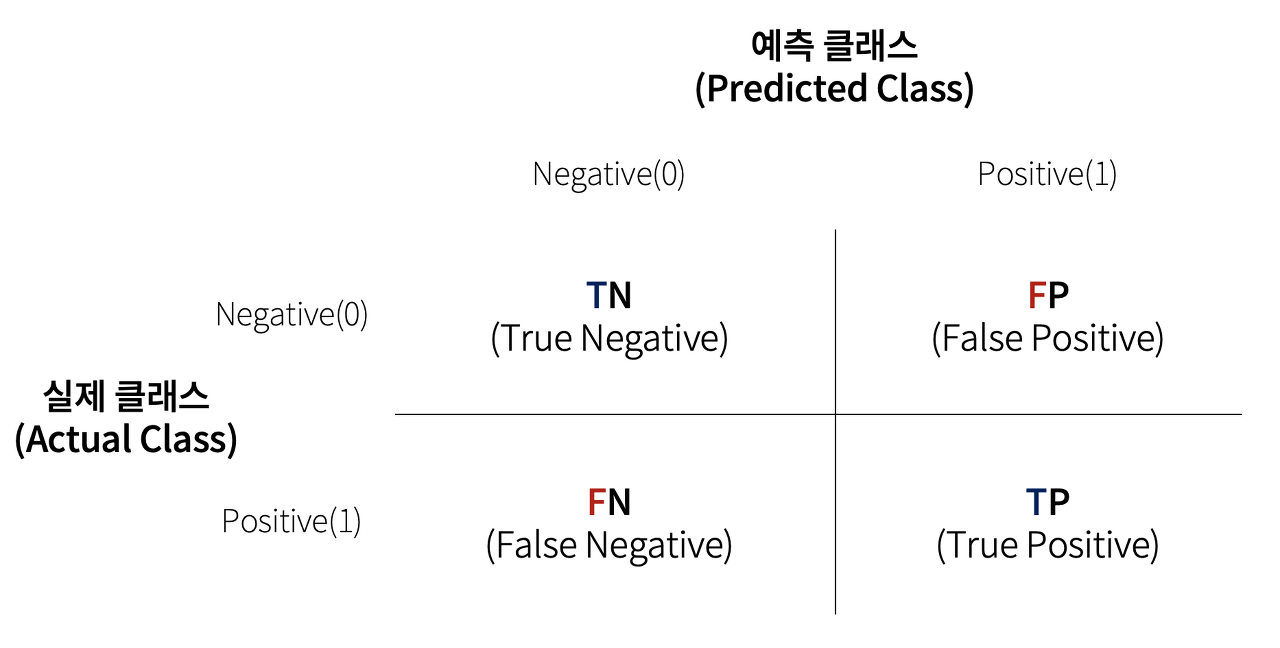

In [ ]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* 정밀도: 양성 예측의 정확도

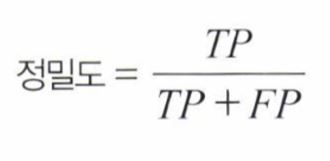

* 재현율: 분류기가 정확하게 감지한 양성 샘플의 비율, 민감도(sensitivity) 또는 진짜 양성 비율(true positive rate, TPR)이라고도 함

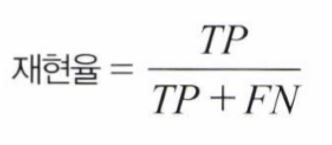

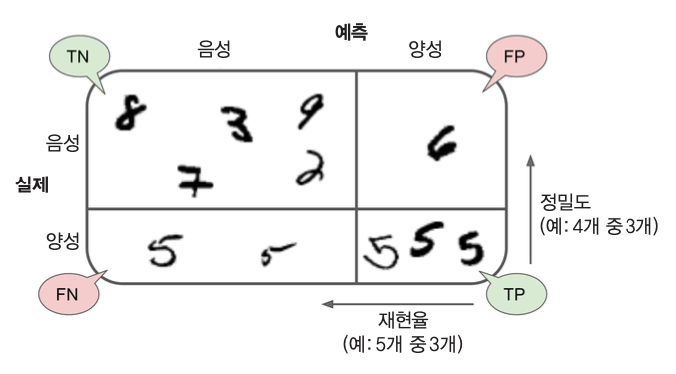

**3.3.3 정밀도와 재현율**

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)  # == 3530/(3530+687)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 3530/(3530+1891)

0.6511713705958311

→ 5로 판별된 이미지 중 83.7%만 정확

→ 전체 숫자 5에서 65.1%만 감지

→ 정밀도와 재현율을 F1 점수라고 하는 하나의 숫자로 만들면 편리함

* F1 점수: 정밀도와 재현율의 조화 평균
$$\text{F}_1 = \frac{2}{\frac{1}{\text{정밀도}} + \frac{1}{\text{재현율}}}$$

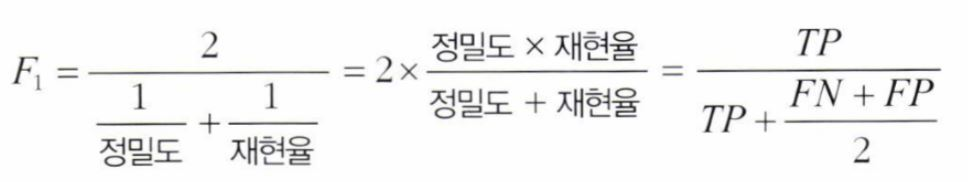

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

→ 정밀도와 재현율이 비슷한 분류기에서는 F<sub>1</sub> 점수가 더 높음

→ 하지만 이게 항상 바람직한 것은 아님 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있음

**3.3.4 정밀도/재현율 트레이드오프**

* 정밀도와 재현율은 상호 반비례 관계임
* 정밀도와 재현율 사이의 적절한 비율을 유지하는 분류기를 찾아야 함
* 적절한 결정 임곗값을 지정해야 함
* 결정 함수(decision function): 분류기가 각 샘플의 점수를 계산할 때 사용
* 결정 임계값(decision threshold): 결정 함수가 양성 클래스 또는 음성 클래스로 분류하는 데에 사용하는 기준값
* 임곗값이 커질수록 정밀도는 올라가지만 재현율은 떨어짐

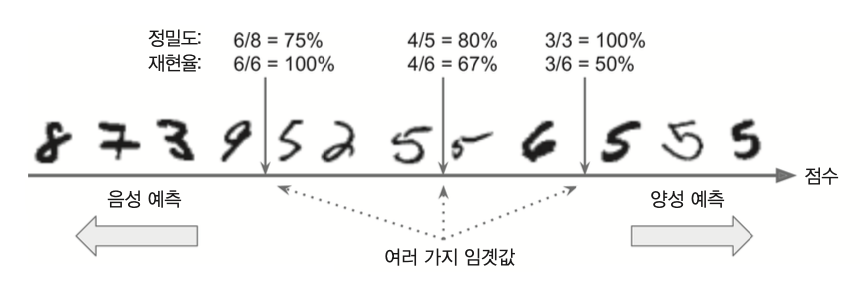

* 사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능
* 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있음
* 이 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있음

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0  # 임곗값
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

→ 임곗값 높이면 재현율이 줄어든다는 것을 보여줌

→ 적절한 임곗값을 정하기 위해 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 함

→ 예측 결과가 아니라 결정 점수를 반환받도록 지정해야 함

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

→ 이 점수로 predcision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율 계산 가능

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

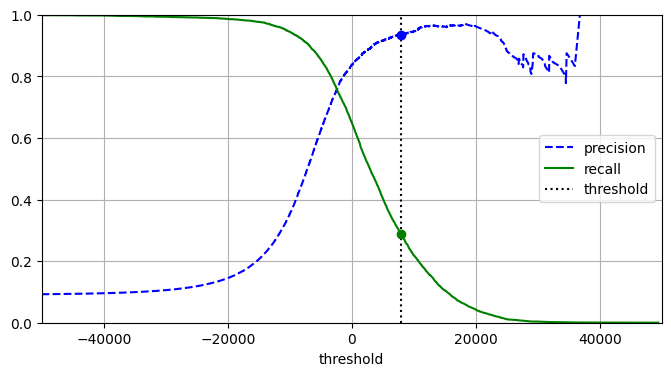

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.figure(figsize=(8, 4))
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="recall")
  plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

  idx = (thresholds >= threshold).argmax()
  plt.plot(thresholds[idx], precisions[idx], "bo")
  plt.plot(thresholds[idx], recalls[idx], "go")
  plt.axis([-50000, 50000, 0, 1])
  plt.grid()
  plt.xlabel('threshold')
  plt.legend(loc="center right")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

→ 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문에 정밀도 곡선이 재현율 곡선보다 더 울퉁불퉁함

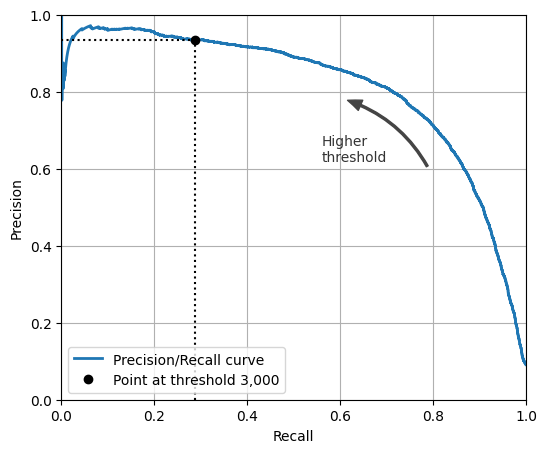

In [ ]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

idx = (thresholds >= threshold).argmax()
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

→ 좋은 정밀도/재현율 트레이드오프를 선택하는 다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것(표시된 임곗값은 앞에서와 동일)

→ 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작함. 이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음

In [ ]:
# 정밀도 90%를 달성하는 것이 목표라고 가정 → 임곗값 약 8000 정도
# 조금 더 정확하게 최소한 90% 정밀도가 되는 가장 낮은 임곗값을 찾을 수 있음 → np.argmax(): 최댓값의 첫 번째 인덱스 반환
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [ ]:
# 예측에 대한 정밀도 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
# 재현율
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

**3.3.5 ROC 곡선**

* 수신기 조작 특성(receiver operating characteristic, ROC) 곡선을 활용하여 이진 분류기의 성능 측정 가능

* ROC 곡선: 거짓 양성 비율(false positive rate, FPR)에 대한 진짜 양성 비율(true positive rate, TPR, 재현율의 다른 이름)의 관계를 나타내는 곡선
    * 결정 임곗값에 따른 두 비율의 변화를 곡선으로 보여줌
    * 거짓 양성 비율: 양성으로 잘못 분류된 음성 샘플의 비율
    * FPR = 1 - TNR(진짜 음성 비율=특이도)
    * ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

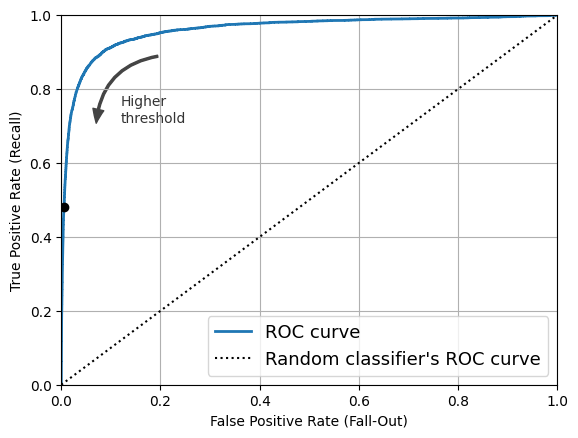

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")  # 대각 점선
  plt.xlabel('False Positive Rate (Fall-Out)')
  plt.ylabel('True Positive Rate (Recall)')
  plt.grid()
  plt.axis([0, 1, 0, 1])
  plt.legend(loc="lower right", fontsize=13)

plot_roc_curve(fpr, tpr, "ROC curve")
# 추가 코드
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.show()

→ 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어남(트레이드오프)

→ 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 함(왼쪽 위 모서리)

* 곡선 아래의 면적(area under the curve, AUC)을 측정하면 분류기들 비교 가능
* 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교

In [ ]:
# RandomForestClassifier로 훈련
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
# RandomFoerstClassifier에는 decision_function() 메서드가 없고 대신 predict_proba() 메서드가 있음

In [ ]:
y_scores_forest = y_probas_forest[:, 1]  # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

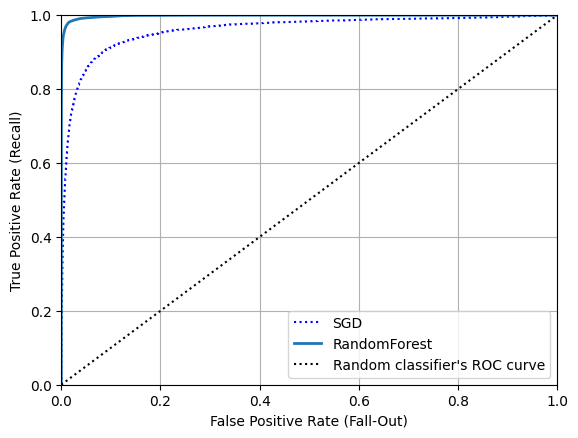

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest")
plt.legend(loc="lower right")
plt.show()

→ RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보임

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

→ ROC AUC 점수도 훨씬 높음

###**3.4 다중 분류**

* 다중 분류기(다항 분류기): 둘 이상의 클래스 구별 가능
* SGD, 랜덤포레스트, 나이브 베이즈 분류기 같은 일부 알고리즘으 ㄴ여러 개의 클래스를 직접 처리할 수 있는 반면, 로지스틱 회귀나 서포트 벡터 머신 분류기 같은 다른 알고리즘은 이진 분류만 가능. 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많음
  * 이미지 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택 → OvR(one-versus-the-rest) 전략(또는 OvA(one-versus-all)라고도 부름)
  * 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기 훈련 → OvO(one-versus-one) 전략, 클래스가 N개라면 분류기는 N(N-1)/2개 필요(MNIST 문제에서는 45개의 분류기 훈련시켜야 함)
  * OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것
  * 서포트 벡터 머신 같은 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇 개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므로 OvO를 선호하지만 대부분의 이진 분류 알고리즘에는 OvR을 선호함
* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO 실행

In [ ]:
# sklearn.svm.SVC 클래스를 사용해 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

→ 5를 구별한 타깃 클래스(y_train_5) 대신 0에서 9까지의 원래 타깃 클래스(y_train)를 사용해 SVC 훈련

→ 그런 다음 예측 하나를 만듦(정확히 맞춤)

→ 내부에서는 사이킷런이 OvO 전략을 사용해 10객의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

→ 가장 높은 점수가 클래스 5에 해당하는 값

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

* 사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용

In [ ]:
# SVC 기반으로 OvR 전략을 사용하는 다중 분류기
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
# SGDClassifier 훈련
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

→ SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO를 적용할 필요 없음

In [ ]:
# decision_function() 메서드는 클래스마다 하나의 값 반환
# SGD 분류기가 클래스마다 부여한 점수 확인
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
# cross_val_score() 함수 사용해 SGDClassifier의 정확도 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
# 입력의 스케일 조정하면 정확도 높일 수 있음
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

###**3.5 에러 분석**

* 모델의 성능을 향상시킬 방법 → 에러의 종류를 분석

In [ ]:
# 오차 행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

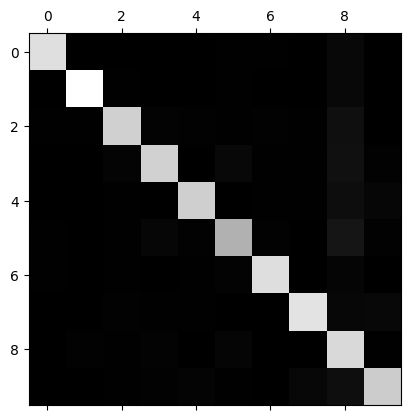

In [ ]:
# 오차 행렬을 맷플롯립의 matshow() 함수를 사용해 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

→ 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보임

→ 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데 이는 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻

In [ ]:
# 그래프의 에러 부분에 초점 맞춰 오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

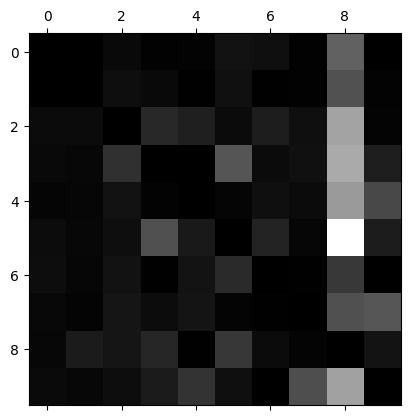

In [ ]:
# 다른 항목 그대로 유지하고 주대각선만 0으로 채워 그래프
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

→ 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄

→ 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음 암시

→ 하지만 클래스 8의 행은 그리 나쁘지 않음. 이는 실제 8이 적절히 8로 분류되었다는 것을 말해줌

→ 오차 행렬은 반드시 대칭인 것은 아님

In [ ]:
# 숫자 그림을 위한 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

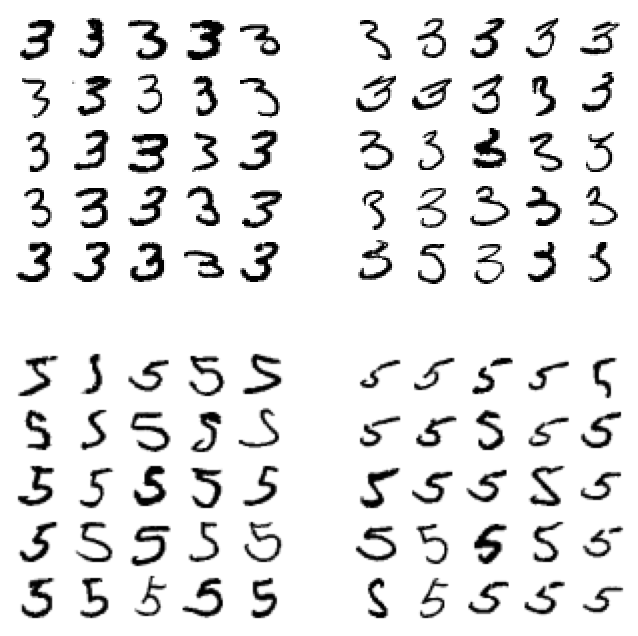

In [ ]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train ==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train ==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train ==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train ==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

→ 분류기가 실수한 원인은 선형 모델인 SGDClassifier를 사용했기 때문

→ 선형 분류기는 클래스마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산함. 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동

→ 분류기가 이미지의 위치나 회전 방향에 매우 민감

→ 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하면 다른 에러도 줄어들 것

###**3.6 다중 레이블 분류**

* 분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음
* 다중 레이블 분류: 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

→ 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦

→ 첫 번째는 숫자가 큰 값 (7, 8, 9)인지 나타내고 두 번째는 홀수인지 나타냄

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

→ 올바르게 분류됨. 숫자 5는 크지 않고(False) 홀수(True)임

In [ ]:
# 다중 레이블 분류기 평가 방법 중 하나 → F1 점수 평균 계산
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

→ 모든 레이블의 가중치가 같지 않을 경우 레이블에 클래스의 지지도를 가중치로 두면 됨. 이전 코드에서 average="weighted"로 설정

###**3.7 다중 출력 분류**

* 다중 출력 분류(multioutput classification): 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것(즉 값을 두 개 이상 가질 수 있음)

ex) 이미지에서 잡음을 제거하는 시스템
* 잡음이 많은 숫자 이미지를 입력으로 받고 깨끗한 숫자 이미지를 MNIST 이미지처럼 픽셀의 강도를 담은 배열로 출력
* 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러 개 가짐(0부터 255까지 픽셀 강도)

In [ ]:
# MNIST 이미지에서 추출한 훈련 세트와 테스트 세트에 넘파이의 randint() 함수 사용하여 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0

# 숫자 이미지를 그리는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

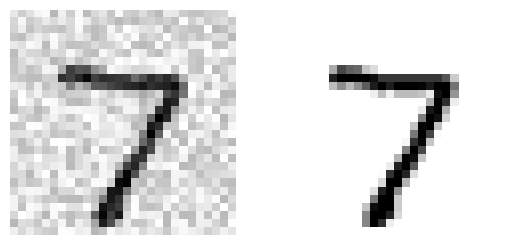

In [ ]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

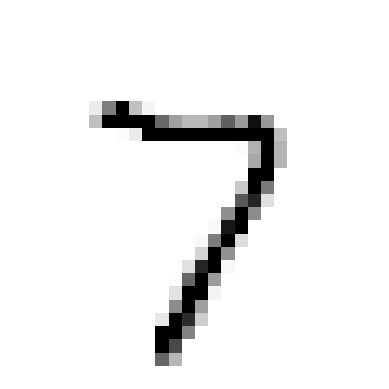

In [ ]:
# 분류기 훈련시켜 이미지 깨끗하게 만들
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)